# Topic Modeling — CSV Files

In these lessons, we're learning about a text analysis method called *topic modeling*. This method will help us identify the main topics or discourses within a collection of texts a single text that has been separated into smaller text chunks.

---

## Dataset

### Am I the Asshole?

```{epigraph}
AITA for lying about my biggest fear on a quiz show and subsequently winning a car and making other contestants lose?

-- Reddit user iwonacar, [r/AmItheAsshole](https://www.reddit.com/r/AmItheAsshole/comments/dmfsum/aita_for_lying_about_my_biggest_fear_on_a_quiz/)
```

In this particular lesson, we're going to use [Little MALLET Wrapper](https://github.com/maria-antoniak/little-mallet-wrapper), a Python wrapper for [MALLET](http://mallet.cs.umass.edu/topics.php), to topic model a CSV file with 2,932 Reddit posts from the subreddit [r/AmITheAsshole](https://www.reddit.com/r/AmItheAsshole/) that have at least an upvote score of 2,000. This is an online forum where people share their personal conflicts and ask the community to judge who's the a**hole in the story. This data was collected with PSAW, a wrapper for the Pushshift API.

___

```{attention}
If you're working in this Jupyter notebook on your own computer, you'll need to have both the Java Development Kit and MALLET pre-installed. For set up instructions, please see [the previous lesson](http://melaniewalsh.github.io/Intro-Cultural-Analytics/Text-Analysis/Topic-Modeling-Set-Up.html).

*If you're working in this Jupyter notebook in the cloud via Binder, then the Java Development Kit and Mallet will already be installed. You're good to go!
```

## Set MALLET Path

Since Little MALLET Wrapper is a Python package built around MALLET, we first need to tell it where the bigger, Java-based MALLET lives.

We're going to make a variable called `path_to_mallet` and assign it the file path of our MALLET program. We need to point it, specifically, to the "mallet" file inside the "bin" folder inside the "mallet-2.0.8" folder. 

In [1]:
path_to_mallet = 'mallet-2.0.8/bin/mallet'

If MALLET is located in another directory, then set your `path_to_mallet` to that file path.

## Install Packages

In [2]:
#!pip install little_mallet_wrapper
#!pip install seaborn
#To install the most updated version of little_mallet_wrapper:
#!!pip install git+https://github.com/maria-antoniak/little-mallet-wrapper.git

## Import Packages

Now let's `import` the `little_mallet_wrapper` and the data viz library `seaborn`.

In [3]:
import little_mallet_wrapper
import seaborn
import glob
from pathlib import Path
import pandas as pd
import random
pd.options.display.max_colwidth = 100

We're also going to import [`glob`](https://docs.python.org/3/library/glob.html) and [`pathlib`](https://docs.python.org/3/library/pathlib.html#basic-use) for working with files and the file system.

## Get Training Data From CSV File

Before we topic model the Reddit posts, we need to process the posts and prepare them for analysis. The steps below demonstrate how to process texts if they come from a CSV file.

```{note}
We're calling these text files our *training data*, because we're *training* our topic model with these texts. The topic model will be learning and extracting topics based on these texts.
```

In [4]:
reddit_df = pd.read_csv("../data/top-reddit-aita-posts.csv")

In [5]:
reddit_df.head()

,author,full_date,date,title,selftext,url,subreddit,upvote_score,num_comments,num_crossposts
0,Additional-Pizza-805,2020-07-24 19:13:49+00:00,2020-07-24,AITA for kicking my cousin off of my sister’s wedding Zoom call?,My [27M] older sister [30F] and her fiancé [31M] were planning for over a year for their wedding...,https://www.reddit.com/r/AmItheAsshole/comments/hx80wd/aita_for_kicking_my_cousin_off_of_my_sist...,AmItheAsshole,11159,2209,4
1,decadel8ter,2020-07-24 14:37:13+00:00,2020-07-24,AITA for resenting my family for something that happened over a decade ago?,when i was 15 i was in a car accident. i was riding my bike on new bike lanes that my city had i...,https://www.reddit.com/r/AmItheAsshole/comments/hx2vvl/aita_for_resenting_my_family_for_somethin...,AmItheAsshole,2541,1143,0
2,Snoo_66130,2020-07-24 12:35:35+00:00,2020-07-24,AITA for telling my step dad to stop trying to be my dad?,"I'm 35, and my mom who is 52 is dating a man who is is 27. This is fucking weird as hell and...",https://www.reddit.com/r/AmItheAsshole/comments/hx0zk7/aita_for_telling_my_step_dad_to_stop_tryi...,AmItheAsshole,2809,1253,1
3,ohnoihaveabluechair,2020-07-24 10:56:56+00:00,2020-07-24,AITA for confronting my SIL for wearing clothes that belonged to me?,"Some info: A few years ago, my family didn’t have a lot of spare money to buy a lot of things (l...",https://www.reddit.com/r/AmItheAsshole/comments/hwzpbu/aita_for_confronting_my_sil_for_wearing_c...,AmItheAsshole,7581,1550,1
4,FormalLettuce3,2020-07-24 10:52:08+00:00,2020-07-24,AITA for saying we'd only help with my ex's kid's party if we could tell people we're engaged?,"This guy, ""Jack"", and I were together for about a year, and within a couple weeks of ending it I...",https://www.reddit.com/r/AmItheAsshole/comments/hwzncq/aita_for_saying_wed_only_help_with_my_exs...,AmItheAsshole,2915,1214,0


In [6]:
reddit_df['selftext'] = reddit_df['selftext'].astype(str)

### Process Reddit Posts

`little_mallet_wrapper.process_string(text, numbers='remove')`

Next we're going to process our texts with the function `little_mallet_wrapper.process_string()`. This function will take every individual post, transform all the text to lowercase as well as remove stopwords, punctuation, and numbers, and then add the processed text to our master list `training_data`.

In [7]:
training_data = [little_mallet_wrapper.process_string(text, numbers='remove') for text in reddit_df['selftext']]

In [8]:
original_texts = [text for text in reddit_df['selftext']]

### Process Reddit Post Titles

We're also going to extract the file name for each Reddit post.

In [9]:
reddit_titles = [title for title in reddit_df['title']]

### Get Dataset Statistics

We can get training data summary statisitcs by using the funciton `little_mallet_wrapper.print_dataset_stats()`.

In [10]:
little_mallet_wrapper.print_dataset_stats(training_data)

Number of Documents: 2932
Mean Number of Words per Document: 147.5
Vocabulary Size: 18729


## Training the Topic Model

`little_mallet_wrapper.train_topic_model(path_to_mallet,
                      path_to_formatted_training_data,
                      path_to_model,
                      path_to_topic_keys,
                      path_to_topic_distributions,
                      num_topics)`

We're going to train our topic model with the `little_mallet_wrapper.train_topic_model()` function. As you can see above, however, this function requires 6 different arguments and file paths to run properly:

- `path_to_mallet`
- `path_to_formatted_training_data`
- `path_to_model`
- `path_to_topic_keys`
- `path_to_topic_distributions`
- `num_topics`

So we have to set a few things up first.

## Set Number of Topics

We need to make a variable `num_topics` and assign it the number of topics we want returned.

In [11]:
num_topics = 15

## Set Training Data

We already made a variable called `training_data`, which includes all of our processed Reddit post texts, so we can just set it equal to itself.

In [12]:
training_data = training_data

## Set Other MALLET File Paths

Then we're going to set a file path where we want all our MALLET topic modeling data to be dumped. I'm going to output everything onto my Desktop inside a folder called "topic-model-output" and a subfolder specific to the Reddit posts called "Reddit."

All the other necessary variables below `output_directory_path` will be automatically created inside this directory.

In [13]:
#Change to your desired output directory
output_directory_path = 'topic-model-output/reddit'

#No need to change anything below here
Path(f"{output_directory_path}").mkdir(parents=True, exist_ok=True)

path_to_training_data           = f"{output_directory_path}/training.txt"
path_to_formatted_training_data = f"{output_directory_path}/mallet.training"
path_to_model                   = f"{output_directory_path}/mallet.model.{str(num_topics)}"
path_to_topic_keys              = f"{output_directory_path}/mallet.topic_keys.{str(num_topics)}"
path_to_topic_distributions     = f"{output_directory_path}/mallet.topic_distributions.{str(num_topics)}"

## Import Data

We're going to import the data with `little_mallet_wrapper.import_data()`.

In [14]:
little_mallet_wrapper.import_data(path_to_mallet,
                path_to_training_data,
                path_to_formatted_training_data,
                training_data)

Importing data...
Complete


## Train Topic Model

Then we're going to train our topic model with `little_mallet_wrapper.train_topic_model()`. The topic model should take about 1-1.5 minutes to train and complete. 

In [15]:
little_mallet_wrapper.train_topic_model(path_to_mallet,
                      path_to_formatted_training_data,
                      path_to_model,
                      path_to_topic_keys,
                      path_to_topic_distributions,
                      num_topics)

Training topic model...
Complete


## Display Topics and Top Words

To examine the 15 topics that the topic model extracted from the Reddit posts, run the cell below. This code uses the `little_mallet_wrapper.load_topic_keys()` function to read and process the MALLET topic model output from your computer, specifically the file "mallet.topic_keys.15".

In [16]:
topics = little_mallet_wrapper.load_topic_keys(path_to_topic_keys)

for topic_number, topic in enumerate(topics):
    print(f"✨Topic {topic_number}✨\n\n{topic}\n")

✨Topic 0✨

['food', 'eat', 'said', 'eating', 'dinner', 'one', 'make', 'vegan', 'restaurant', 'table', 'cook', 'meat', 'meal', 'made', 'like', 'drink', 'cooking', 'order', 'home', 'something']

✨Topic 1✨

['like', 'time', 'get', 'doesn', 'want', 'feel', 'every', 'work', 'really', 'together', 'day', 'always', 'make', 'going', 'way', 'even', 'something', 'home', 'times', 'things']

✨Topic 2✨

['told', 'didn', 'said', 'got', 'went', 'friends', 'asked', 'wanted', 'going', 'ago', 'would', 'back', 'boyfriend', 'time', 'since', 'know', 'never', 'saying', 'wasn', 'started']

✨Topic 3✨

['house', 'room', 'dog', 'door', 'home', 'live', 'bathroom', 'get', 'apartment', 'one', 'would', 'use', 'back', 'living', 'place', 'roommate', 'sleep', 'bed', 'put', 'away']

✨Topic 4✨

['said', 'told', 'like', 'got', 'started', 'went', 'didn', 'asked', 'back', 'get', 'really', 'could', 'right', 'came', 'say', 'trying', 'help', 'even', 'took', 'know']

✨Topic 5✨

['money', 'pay', 'school', 'would', 'job', 'get', 

## Load Topic Distributions

MALLET also calculates the likely mixture of these topics for every single Reddit post in the corpus. This mixture is really a probability distribution, that is, the probability that each topic exists in the document. We can use these probability distributions to examine which of the above topics are strongly associated with which specific posts.

To get the topic distributions, we're going to use the `little_mallet_wrapper.load_topic_distributions()` function, which will read and process the MALLET topic model output, specifically the file "mallet.topic_distributions.15". 

In [17]:
topic_distributions = little_mallet_wrapper.load_topic_distributions(path_to_topic_distributions)

In [18]:
topic_distributions[0]

[0.012152777777777778,
 0.06423611111111112,
 0.13194444444444445,
 0.006944444444444444,
 0.027777777777777776,
 0.017361111111111112,
 0.44965277777777773,
 0.06944444444444445,
 0.001736111111111111,
 0.03819444444444444,
 0.11631944444444443,
 0.001736111111111111,
 0.03298611111111111,
 0.001736111111111111,
 0.027777777777777776]

It's a bit easier to understand if we pair these probabilities with the topics themselves. As you can see below, Topic 6 "family wedding party want birthday would" has a relatively high probability of existing in the Reddit post "AITA for not attending holiday gatherings?" `.124` while Topic 14 "dog cats dog house would take" has a relatively low probability `.006`.

In [19]:
reddit_post_to_check = "AITA for lying about my biggest fear on a quiz show and subsequently winning a car and making other contestants lose?"

reddit_post_number = reddit_titles.index(reddit_post_to_check)

print(f"Topic Distributions for {reddit_titles[reddit_post_number]}\n")
for topic_number, (topic, topic_distribution) in enumerate(zip(topics, topic_distributions[reddit_post_number])):
    print(f"✨Topic {topic_number} {topic[:6]} ✨\nProbability: {round(topic_distribution, 3)}\n")

Topic Distributions for AITA for lying about my biggest fear on a quiz show and subsequently winning a car and making other contestants lose?

✨Topic 0 ['food', 'eat', 'said', 'eating', 'dinner', 'one'] ✨
Probability: 0.002

✨Topic 1 ['like', 'time', 'get', 'doesn', 'want', 'feel'] ✨
Probability: 0.012

✨Topic 2 ['told', 'didn', 'said', 'got', 'went', 'friends'] ✨
Probability: 0.059

✨Topic 3 ['house', 'room', 'dog', 'door', 'home', 'live'] ✨
Probability: 0.112

✨Topic 4 ['said', 'told', 'like', 'got', 'started', 'went'] ✨
Probability: 0.059

✨Topic 5 ['money', 'pay', 'school', 'would', 'job', 'get'] ✨
Probability: 0.133

✨Topic 6 ['wedding', 'party', 'would', 'birthday', 'one', 'day'] ✨
Probability: 0.017

✨Topic 7 ['said', 'like', 'really', 'friend', 'told', 'friends'] ✨
Probability: 0.059

✨Topic 8 ['would', 'years', 'wife', 'know', 'life', 'never'] ✨
Probability: 0.18

✨Topic 9 ['name', 'first', 'people', 'think', 'know', 'last'] ✨
Probability: 0.028

✨Topic 10 ['sister', 'mom', 'f

## Explore Heatmap of Topics and Texts

We can visualize and compare these topic probability distributions with a heatmap by using the `little_mallet_wrapper.plot_categories_by_topics_heatmap()` function.

We have everything we need for the heatmap except for our list of `target_labels`, the sample of texts that we'd like to visualize and compare with the heatmap. Below we make our list of desired target labels by randomly selecting 6 Reddit post titles.

In [55]:
target_labels = random.sample(reddit_titles, 6)

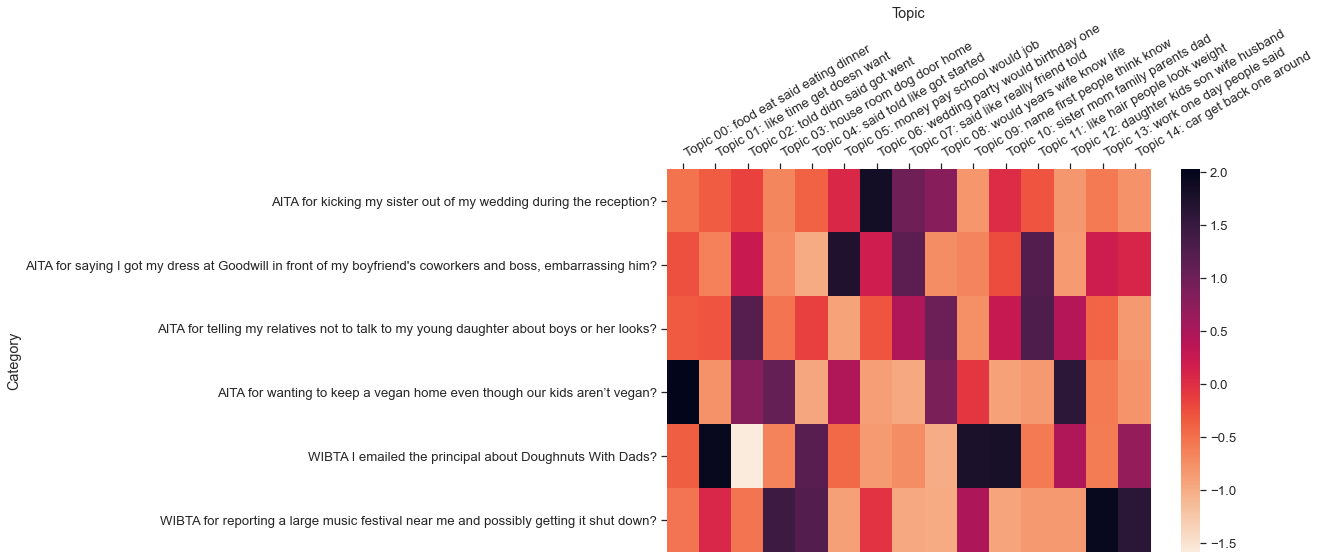

In [56]:
little_mallet_wrapper.plot_categories_by_topics_heatmap(reddit_titles,
                                      topic_distributions,
                                      topics, 
                                      output_directory_path + '/categories_by_topics.pdf',
                                      target_labels=target_labels,
                                      dim= (18, 8)
                                     )

The `plot_categories_by_topics_heatmap()` function also helpfully outputs a PDF of the heatmap to `output_directory_path + '/categories_by_topics.pdf'`. We can download this PDF and explore it in more detail or embed it in an article or blog post!

In [62]:
from IPython.display import IFrame
IFrame("topic-model-output/reddit/categories_by_topics.pdf", width=1000, height=600)

## Display Top Titles Per Topic

We can also display the Reddit posts and titles that have the highest probability for every topic with the `little_mallet_wrapper.get_top_docs()` function.

In [41]:
training_data_reddit_titles = dict(zip(training_data, reddit_titles))
training_data_original_text = dict(zip(training_data, original_texts))

We'll make our own function `display_top_titles_per_topic()` that will display the top Reddit post titles for every topic. This function accepts a given `topic_number` as well as a desired `number_of_documents` to display.

In [42]:
def display_top_titles_per_topic(topic_number=0, number_of_documents=5):
    
    print(f"✨Topic {topic_number}✨\n\n{topics[topic_number]}\n")

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):
        print(round(probability, 4), training_data_reddit_titles[document] + "\n")
    return

**Topic 0**

To display the top 5 Reddit post titles with the highest probability of containing Topic 0, we will run:

In [43]:
display_top_titles_per_topic(topic_number=0, number_of_documents=5)

✨Topic 0✨

['years', 'wife', 'would', 'life', 'never', 'relationship', 'time', 'want', 'family', 'married', 'ago', 'last', 'know', 'love', 'like', 'together', 'two', 'things', 'even', 'much']

0.6275 AITA for leaving my three year old son after finding out he isn’t mine and my wife cheated on me?

0.5721 WIBTA if I left my SO while he is in prison?

0.5203 AITA for not allowing my ex-wife 50/50 custody of my daughter?

0.5044 WIBTA if I tell my bio daughter that I don't want to help her or have her in my life because she decided that her stepmom should adopt her once she turned 18?

0.4824 AITA for skipping my child's birth to see my dying father?



**Topic 0 Label**: 

Relationships (Double-click this cell to enter your own label)

**Topic 9**

To display the top 5 Reddit post titles with the highest probability of containing Topic 9, we will run:

In [44]:
display_top_titles_per_topic(topic_number=9, number_of_documents=5)

✨Topic 9✨

['kids', 'son', 'daughter', 'husband', 'baby', 'wife', 'child', 'old', 'told', 'pregnant', 'year', 'children', 'kid', 'want', 'mother', 'would', 'said', 'think', 'father', 'asked']

0.5436 AITA for not caring when our baby is born?

0.5064 AITA for planning a vacation getaway for my two older kids as a thank you gift and leaving my third child with grandma when she contributing nothing?

0.484 AITA for telling my daughter that I will definitely report her to the CPS if she decides to move in with her drug addicted boyfriend?

0.4769 AITA for telling my kids stepmom she isn’t their mom.

0.4738 AITA for choosing my biological child over my foster son?



**Topic 9 Label**: 

Family (Double-click this cell to enter your own label)

**Topic 8**

To display the top 7 Reddit posts with the highest probability of containing Topic 8, we will run:

In [45]:
display_top_titles_per_topic(topic_number=8, number_of_documents=7)

✨Topic 8✨

['money', 'pay', 'job', 'work', 'would', 'paid', 'get', 'got', 'told', 'paying', 'since', 'buy', 'new', 'time', 'house', 'could', 'year', 'car', 'bought', 'said']

0.607 AITA for buying SO's Father's Home and Then Flipping it?

0.5897 AITA for refusing to pay for my boyfriend's new glasses?

0.5655 AITA for refusing to share my extra income with my wife when she didn't share hers with me when she earned more?

0.5598 AITA for having the electricity shut off to our apartment, after my roommates didn't pay their shares of the bill?

0.5193 AITA for not paying my roommate half of the winnings of a scratch off we “split” the cost of

0.5138 AITA for spending my Sons lottery winnings money?

0.5131 AITA for using a gift card I received on something other than what it was intended for?



**Topic 8 Label**: 

Money Problems (Double-click this cell to enter your own label)

## Display Topic Words in Context of Original Text

Often it's useful to actually look at the document that has ranked highly for a given topic and puzzle out why it ranks so highly.

To display the original Reddit post texts that rank highly for a given topic, with the relevant topic words **bolded** for emphasis, we are going to make the function `display_bolded_topic_words_in_context()`.

In the cell below, we're importing two special Jupyter notebook display modules, which will allow us to make the relevant topic words **bolded**, as well as the regular expressions library `re`, which will allow us to find and replace the correct words.

In [46]:
from IPython.display import Markdown, display
import re

def display_bolded_topic_words_in_context(topic_number=3, number_of_documents=3, custom_words=None):

    for probability, document in little_mallet_wrapper.get_top_docs(training_data, topic_distributions, topic_number, n=number_of_documents):
        
        print(f"✨Topic {topic_number}✨\n\n{topics[topic_number]}\n")
        
        probability = f"✨✨✨\n\n**{probability}**"
        reddit_title = f"**{training_data_reddit_titles[document]}**"
        original_text = training_data_original_text[document]
        topic_words = topics[topic_number]
        topic_words = custom_words if custom_words != None else topic_words

        for word in topic_words:
            if word in original_text:
                original_text = re.sub(f"\\b{word}\\b", f"**{word}**", original_text)

        display(Markdown(probability)), display(Markdown(reddit_title)), display(Markdown(original_text))
    return

**Topic 3**

To display the top 3 original Reddit posts with the highest probability of containing Topic 0 and with relevant topic words bolded, we will run:

In [47]:
display_bolded_topic_words_in_context(topic_number=3, number_of_documents=3)

✨Topic 3✨

['dog', 'take', 'get', 'told', 'care', 'pain', 'could', 'would', 'cat', 'even', 'hospital', 'got', 'dogs', 'health', 'doctor', 'one', 'removed', 'getting', 'know', 'aita']



✨✨✨

**0.5303030303030303**

**AITA for causing a scene in the hospital over an IV?**

I needed to have a surgery last week. I **told** my surgeon I have a fear of needles and he **told** me he **would** write a note to **get** me a lidocaine shot. Yes it’s a shot but it’s not **getting** a fat needle stuck in me. It reduces the **pain** of the IV needle by 99%. Anyways I went to my pre op testing and **told** them I was afraid of needles. They also made a note to give me a lidocaine shot before **getting** the IV. I **get** to the **hospital** and the nurses already knew about the lidocaine shot. Well I **got** this cranky nurse who was in a bad mood. I usually joke around with nurses to ease my fears but she wasn’t taking it. She’s going solo with my IV and I asked her about the lidocaine shot and she **told** me I’m too old to **get** a lidocaine shot. She was about to stick in the giant ass IV with no numbing medication. 



She tried to grab my arm but I wasn’t having it. She wasn’t the nicest person.  I **got** up out of my bed and **told** the other nurses about my lidocaine shot. I was in my gown and disconnected my leads. They finally gave me my lidocaine shot and I felt no **pain** when the IV went in. 


I feel like a jerk for being extra like that but I hate needles and forever will.

✨Topic 3✨

['dog', 'take', 'get', 'told', 'care', 'pain', 'could', 'would', 'cat', 'even', 'hospital', 'got', 'dogs', 'health', 'doctor', 'one', 'removed', 'getting', 'know', 'aita']



✨✨✨

**0.440251572327044**

**AITA for walking my cat on a trail frequented by dogs?**

I live in a condo building and letting my **cat** out is not an option, so he is trained to go for walks on a leash. We like to go to trail near the woods to he can roll in the tall grass and climb trees. He has no issues with **dogs**, but **dogs** will growl at him. He does not **care**, but I can tell it pisses the **dog** owners off. I figure we have just as much right to be there as them. I **get** the whole **dogs** chase cats thing, but Bubba shouldn’t suffer just because you can’t control your **dog**. Cat tax https://i.imgur.com/IyMKfbQ.jpg

✨Topic 3✨

['dog', 'take', 'get', 'told', 'care', 'pain', 'could', 'would', 'cat', 'even', 'hospital', 'got', 'dogs', 'health', 'doctor', 'one', 'removed', 'getting', 'know', 'aita']



✨✨✨

**0.41854636591478694**

**WIBTA If I put my dog to sleep when my family goes on vacation?**

Our **dog**, who is a pug and is 12 years old, was diagnosed with a malignant sarcoma on his upper gum about 5 months ago. We visited 5 vets; all have **told** us that while they can perform surgery and de-bulk the tumor, the tumor will grow back. Chemo is around $450 a month, FOR THE REST OF HIS LIFE. Surgery **would** be $1500 - $4500. Every vet has strongly suggested that we humanely euthanize him sooner than later. We reached out to a traveling vet that euthanizes pets at home. He specifically **told** us that we should think about our **dog**’s quality of life and to also think about the mental anguish that he will specifically face when he euthanizes a **dog** in agonizing **pain**.

With all that being said, we started giving him RSO, THC and CBD versions along with gabapentin, tramadol, and prednisone. One of the cannabis products we give him is CBD companion, which is bacon flavored CBD oil that comes with an eye dropper. The vet has also been gracious to give us 90 day supplies of medications.

My wife and I agreed that our **dog** **would** let us **know** when it was time for him to pass. Before his diagnoses, we planned to visit family out of country, me for 2 weeks and her for 2 months with the kids. I cancelled my trip to **take** **care** of our **dog** at the request of her a month or so after his diagnoses. Everything was going well, until about a month ago.

He stopped taking his pill pockets with his medicine and all but refused to eat. He is constantly panting from **pain** and does not lie down except when he is exhausted from standing all day due to the **pain**. He can barely walk up the stairs, and if I try to pick him up he yelps in **pain**. He has lost a lot of weight. The smell alone from the necrotic flesh is nauseating and it is everywhere in the house, Febreeze only works so much. The carpet continually has new stains where he finally lays down that I clean up.

My wife insisted that we continue to give him his medication, so I started compounding his medication with the bacon oil. That's right, I crush his prednisone pill up, empty the gabapentin capsule, add 3 drops of RSO (I combined the CBD and THC RSO's), with .75 ml of bacon CBD oil. I mix it up together, and then suck it all up in the eye dropper. We then squirt the medicine in his mouth and make him swallow it. We do not give Tramadol this way.

They leave to visit family in less than two weeks. I have tried talking with her about euthanizing him before they go, to let her say good bye, but she refuses. She fully expects him to be alive when they return in August with visiting family. She continually tells me that I am being negative and that if I was more positive that he **would** feel that and **get** better, she has specifically said that she is hoping for a miracle.

I wanted to say good bye 4 months ago, when he **could** still go to the **dog** park, when he **could** still eat a meal without being in tremendous **pain**, when he **could** sleep through the night. WIBTA if I put my **dog** to sleep soon after they go on vacation?

**Topic 8**

To display the top 3 original Reddit posts with the highest probability of containing Topic 8 and with relevant topic words bolded, we will run:

In [49]:
display_bolded_topic_words_in_context(topic_number=14, number_of_documents=5)

✨Topic 14✨

['room', 'house', 'home', 'back', 'time', 'get', 'sleep', 'door', 'work', 'bed', 'night', 'live', 'one', 'use', 'bathroom', 'morning', 'leave', 'stuff', 'apartment', 'told']



✨✨✨

**0.6293532338308457**

**AITA for my morning alarm(s)?**

Hello all, very intrigued as to opinions on the following: 

&amp;#x200B;

I am a heavy sleeper, and I mean a HEAVY sleeper. Because of this my first alarm wakes me up 3.5 hours before my shift at **work** starts, and in case I don't wake up I have alarms every 30 minutes to periodically wake me up and ensure I don't go **back** to **sleep**/oversleep etc so I can **get** to **work** on **time** every day. 

&amp;#x200B;

Lately the person who lives in the **apartment** below me has been banging on the wall/ceiling when my alarm goes off, which I'm guessing is because it goes off at 5.30am. 

&amp;#x200B;

This **morning**, my alarm went off at 5.30am and there was no banging, but I was too tired to **get** up and slapped the snooze button. 5.40am the alarm finishes it's snooze cycle and goes off again, at which point I turn it off. 

&amp;#x200B;

5.45am I hear loud banging on my **apartment** **door**, very aggressive and continuous banging. I would describe it as "open the damn **door**" knocking. I ignore it because I'm too tired to deal with confrontation and I don't want to end up in a shouting match that wakes up the rest of the residents. Then they go downstairs outside the building, and start pressing the buzzer for my **apartment** and just holding it so it's a constantly buzzing. Then I unplug the receiver and the noise stopped. 

&amp;#x200B;

I have emailed my building manager to advise of the situation and for them to suggest the best course of action moving forward, but I have the following questions: 

&amp;#x200B;

1. Am I the asshole because my alarm is too early? 
2. Am I the asshole if I'm a heavy sleeper and require 3/4 alarms over a 2 hour period to wake me up?
3. What actions would you take in response to the actions of my neighbour?

✨Topic 14✨

['room', 'house', 'home', 'back', 'time', 'get', 'sleep', 'door', 'work', 'bed', 'night', 'live', 'one', 'use', 'bathroom', 'morning', 'leave', 'stuff', 'apartment', 'told']



✨✨✨

**0.5771604938271605**

**AITA for refusing to eat my GF cooking because her cats litter is disgusting?**

My GF has two cats. When we got to her place tonight I helped her clean up a bit. I threw some trash away, swept her floors. I was going to do the dishes but her cats litter boxes are in the kitchen and they STINK. I mean, the litter is pilled up with cat shit and piss. It’s disgusting and the smell is horrid. I wanted to clean up while she cooks but I refuse to clean her cats litter boxes. It looks like a mountain of shit and piss.

I clean her kitten litter box sometimes because I can’t stand the smell but I don’t touch the adult cats box. I asked her if she could clean the boxes because they stink. She proceeds to clean the rest of the **house** except for the litter. 

She starts cooking dinner and I tell her “I don’t have an appetite you can put the left overs in the fridge” she thinks I’m being dramatic about the smell and whenever I suggest she cleans the litter she gets all pissy, frustrated and walks off 

I just don’t have an appetite to eat food that’s prepared in a kitchen with mounds of poop and piss sitting in the box smelling up the **house**. 

So am I just being a dramatic asshole about not eating my GF cooking because of the nasty litter boxes?

✨Topic 14✨

['room', 'house', 'home', 'back', 'time', 'get', 'sleep', 'door', 'work', 'bed', 'night', 'live', 'one', 'use', 'bathroom', 'morning', 'leave', 'stuff', 'apartment', 'told']



✨✨✨

**0.5691056910569106**

**AITA for shutting off the power to my neighbor's apartment to stop the sound of loud pornography?**

I **live** in a building where the breaker box is at the entrance of my building. My **door** is on **one** side of the breaker box, my neighbor's **door** on the other. My son was over (he's 10 and I see him on weekends because his mom has him during the week) and my neighbor (a man in his 40s) was blasting porn on his TV.  We were trying to play guitar together and then I just had it: I went to the breaker box and turned the power to his **apartment** off and then on again. This reset his WIFI and TV. There was no more loud porn after that.

✨Topic 14✨

['room', 'house', 'home', 'back', 'time', 'get', 'sleep', 'door', 'work', 'bed', 'night', 'live', 'one', 'use', 'bathroom', 'morning', 'leave', 'stuff', 'apartment', 'told']



✨✨✨

**0.5566188197767145**

**WIBTA if I told my roommate his girlfriend is getting too comfortable in our home?**

I **live** with **one** roommate and I have a cat. We have a two bedroom, **one** bath **home** that we split everything evenly on. Half rent, half utilities, half **bathroom** space. The bedrooms are also directly next to **one** another. His bedroom **door** cannot be closed all the way due to the frame being slightly too small, so if you close it all the way it's going to be areal bitch to open again. I never close my **door** all the way because my cat always sleeps with me, but her food and litter box are outside of my **room** so our doors typically stay open all the **time**. This isn't really ever a problem with us. I've never been awaken by him and he's never been awaken by me. However, when his girlfriend comes over I'm awoken at around 9am EVERY **morning**. Due to my **work** schedule I don't **get** up until noon and usually go to **sleep** around 5am. She's here every Friday-Monday so basically all those mornings I **get** woken up by her shouting from the **bathroom** to my roommate in his **room**. Or from the kitchen. Sometimes she talks directly in front of my **door** at full volume to my roommate when he's in his **room**.

Then there's the **bathroom** issue. Every weekend our **bathroom** becomes more and more populated with her **stuff**. I often find my **stuff** completely moved from where I put it. Sometimes it's moved from inside cabinets to on top of cabinets. I should mention our **bathroom** is small. We have two shelves that my roommate and I decided he gets **one**, I **get** the other. Where is her **stuff**? She has an entire shelf all to her self with some of her **stuff** now on my shared shelf with my roommate. Was I asked how I felt about this or if it was okay with me? Nope. She also has an ungodly amount of body washes, shampoos, conditioners, other shit I'm not even sure what their purpose is all in the tub. We don't even have shelf space for it, so what do they do? Move my shit to the floor so I have to reach out of the shower to **get** my shampoo.

I think she's too comfortable. She's not on the lease but acts as if she pays rent. I'm tired of being tired on the weekends and I'm tired of searching through shit to find my shit to move it **back** to it's place just to have someone move it again. I'm going to tell my roommate she needs to keep her **stuff** in his **room** or they can go to her place and then she can make all the noise she wants whenever she wants. I guess I'm asking if I WIBTA to gauge what I'm going to have to deal with this weekend.

✨Topic 14✨

['room', 'house', 'home', 'back', 'time', 'get', 'sleep', 'door', 'work', 'bed', 'night', 'live', 'one', 'use', 'bathroom', 'morning', 'leave', 'stuff', 'apartment', 'told']



✨✨✨

**0.5494791666666666**

**AITA for confining my husband to one bathroom in our house?**

So this is totally TMI, but this has been an ongoing thing for our entire marriage. Basically, my husband is the messiest **bathroom** user I've ever seen. He leaves pee and shit streaks on the seat, his shit splatters the bowl every **time** he uses it, and he leaves little pieces of toilet paper all over the floor. It's disgusting. 
For the first 3 years of our marriage we lived in places with only **one** **bathroom**. I would beg him to clean up after himself, but most of the **time** he said he didn't see anything wrong. I ended up cleaning the **bathroom** almost every other day. When we bought our **house** it somehow got even worse, so by then I had had enough. I **told** him he could **use** the toilet in the master **bathroom**, and I would **use** the **one** by the guest rooms. 
This has worked out well for the most part. I keep my **bathroom** clean, and I don't step foot in the toilet **room** in our master **bathroom**. I never clean it. I don't even keep tampons in there anymore. 
Despite this arrangement, my husband sometimes still uses MY **bathroom**, and it makes me irritated. He says that sometimes it just more convenient to **use** that **bathroom**, and that it's his **house** too, so he should be able to go where he wants. My thought is that since he has chased me out of the **bathroom** connected to our bedroom, and that I have to walk across the **house** to pee at **night**, then he can at least respect my **bathroom** and go **use** the other **one**. AITA?